In [1]:
!python --version

Python 3.13.5


In [54]:
import gc
import os
from PIL import Image

import torch
import torchvision
import numpy as np
np.random.seed(2025 - 6 - 20)
from numpy.typing import NDArray
import matplotlib.pyplot as plt

In [76]:
os.listdir(r"../cowpea/"); # images are named 1 to 100 <num>.TIF

In [58]:
# what does a convolution kernel do to an image???

image = np.array(Image.open(f"../cowpea/{np.random.randint(low=1, high=100)}.TIF"))
height, width, _ = image.shape

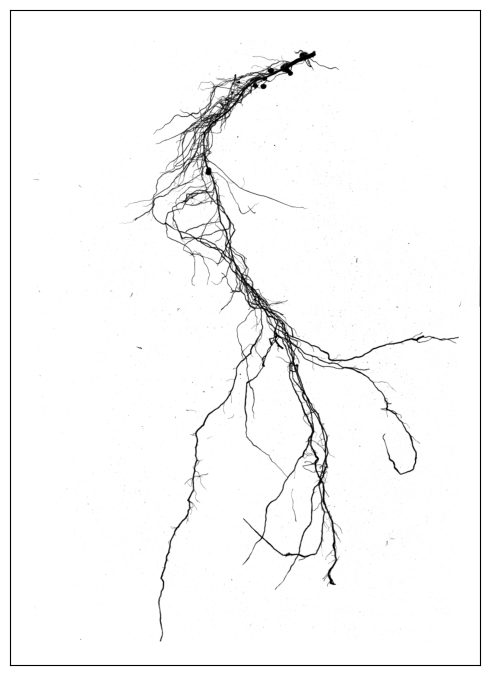

In [59]:
fig, axes = plt.subplots()
fig.set_size_inches(5, 7.5)
axes.imshow(image)
axes.set_xticks([])
axes.set_yticks([])
plt.tight_layout()
plt.show()

In [69]:
def rgb_matrix_to_tensor(image: NDArray[np.uint8]) -> torch.FloatTensor:
    """
    input is expected to be a H x W matrix made of [R, G, B] channels
    i.e (H, W, 3) to (3, H, W)
    """

    height, width, nchannels = image.shape
    if nchannels != 3: # RGB channels expected!!!
        raise RuntimeError(f"Only images using the standard RGB channel pixels are supported! Expected 3 channels, but got {nchannels} channels!")
    
    result = torch.tensor(np.array(np.unstack(image, axis=-1)), # split the image into 3 matrixes for each R, G and B channels
                       dtype=torch.float32)
    
    assert (result.shape[0] == 3) and (result.shape[1] == height) and (result.shape[2] == width), "Shape mismatches between input array and result tensor!"
    return result

def tensor_to_rgb_matrix(tensor: torch.FloatTensor) -> torch.FloatTensor:
    """
    transforms a tensor of R, G & B matrices into a matrix of [R, G, B] pixels
    i.e from (3, H, W) to (H, W, 3)
    """
    
    return np.stack(tensor, axis=-1)

def scale_to_standard_rgb_channels(tensor: torch.FloatTensor|NDArray[np.floating]) -> torch.IntTensor|NDArray[np.uint8]:
    """
    scales a tensor or array of floats with unknown bounds into a tensor or array of uint8s with an inclusive range [0, 255]
    """
    
    tensor += abs(tensor.min()) # probably a negative value, hence the abs()
    tensor /= tensor.max() # downscale to [0.00, 1.00]
    tensor *= 255 # upscale to RGB channel max 255
    return tensor.type(torch.uint8) if isinstance(tensor, torch.Tensor) else tensor.astype(np.uint8)

In [70]:
with torch.no_grad():
    convolved = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(10, 10))(rgb_matrix_to_tensor(image))

In [71]:
convolved.shape, image.shape

(torch.Size([3, 3069, 2198]), (3078, 2207, 3))

In [72]:
tensor_to_rgb_matrix(scale_to_standard_rgb_channels(convolved)).min(), tensor_to_rgb_matrix(scale_to_standard_rgb_channels(convolved)).max()

(np.uint8(0), np.uint8(255))

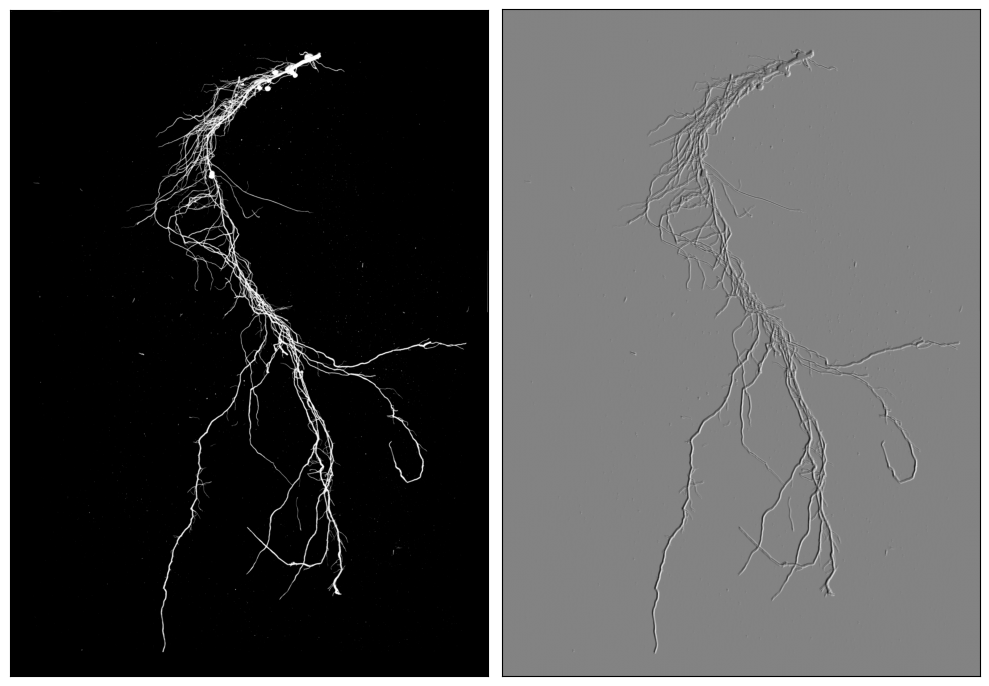

In [74]:
fig, (axes_l, axes_r) = plt.subplots(ncols=2)
fig.set_size_inches(10, 7.5)

axes_l.imshow(image.mean(axis=2), cmap=plt.cm.binary)
axes_l.set_xticks([])
axes_l.set_yticks([])

axes_r.imshow(scale_to_standard_rgb_channels(tensor_to_rgb_matrix(convolved)).mean(axis=2), cmap=plt.cm.binary)
axes_r.set_xticks([])
axes_r.set_yticks([])

plt.tight_layout()
plt.show()

In [81]:
# imitate a forward pass

conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1)
conv2 = torch.nn.Conv2d(32, 64, 3, 1)
dropout1 = torch.nn.Dropout(0.25)
dropout2 = torch.nn.Dropout(0.5)
fc1 = torch.nn.Linear(9216, 128)
fc2 = torch.nn.Linear(128, 10)

step_0 = conv1(rgb_matrix_to_tensor(image))
step_1 = torch.nn.functional.relu(step_0)
step_2 = conv2(step_1)
step_3 = torch.nn.functional.relu(step_2)
step_4 = torch.nn.functional.max_pool2d(step_3, 2)
step_5 = dropout1(step_4)
step_6 = torch.flatten(step_5, 1)
step_7 = fc1(step_6)
step_8 = torch.nn.functional.relu(step_7)
step_9 = dropout2(step_8)
step_10 = fc2(step_9)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1692237 and 9216x128)

In [88]:
[gc.collect(gen) for gen in range(3)]

[0, 0, 0]